# read croco float raw files

In [1]:
import numpy as np
import dask.dataframe as dd
import pandas as pd

import matplotlib.pyplot as plt
import hvplot.pandas
import hvplot.dask

from glob import glob

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

<Client: 'tcp://127.0.0.1:64251' processes=4 threads=4, memory=17.18 GB>

In [4]:
#df = dd.read_csv('data/float.*') # we should rename output files to be able to do this
df = dd.read_csv(glob('data_float/float.????'), 
                 names=['id','time','xgrid','ygrid','zgrid','depth','temp'],
                 delim_whitespace=True).persist()

In [5]:
df.head()

id       time      xgrid      ygrid  zgrid     depth       temp
0  178  1528.3333  234.83958  480.59289   49.0 -7.865468  25.644865
1  178  1528.3750  234.64826  480.75665   49.0 -7.865009  25.643367
2  178  1528.4167  234.45943  480.91663   49.0 -7.864663  25.642758
3  178  1528.4583  234.27268  481.07314   49.0 -7.864471  25.643952
4  178  1528.5000  234.09115  481.22667   49.0 -7.864358  25.646259

## reorganize data: group by ids, add velocity and load as pandas dataframe

In [6]:
ids = df.id.unique().compute().sort_values()

In [7]:
#df.id.unique()
ldf = df.groupby(['id']).get_group(2).compute().sort_values('time').set_index('time')

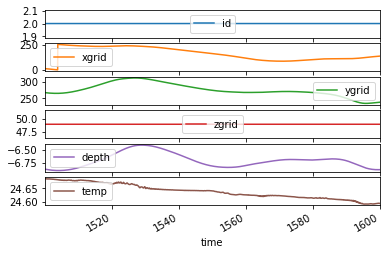

In [8]:
ax = ldf.plot(subplots=True)

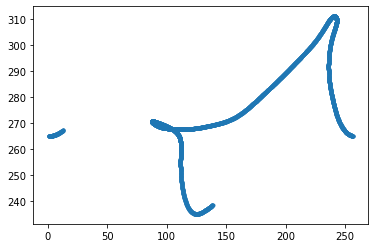

In [9]:
ax = plt.plot(ldf.xgrid,ldf.ygrid,'.')

In [10]:
# L = df['xgrid'].max().compute()
L = 256.6

def add_velocity(d):
    _d = d.sort_values('time').drop(columns='id')
    dt = _d['time'].diff()
    _d['dxdt'] = (_d['xgrid'].apply(lambda x: np.exp(2.*np.pi*1j/L*x))
                  .diff().apply(lambda x: np.real(x)))/dt
    _d['dydt'] = _d['ygrid'].diff()/dt
    return _d #.set_index('time') 

df = df.groupby(['id']).apply(add_velocity, 
                meta={'time': 'f8', #'id': 'i4', #, 
                      'xgrid': 'f8', 'ygrid': 'f8', 'zgrid': 'f8', 
                      'depth': 'f8', 'temp': 'f8', 
                      'dxdt': 'f8', 'dydt': 'f8'})

In [11]:
df.head()

time      xgrid      ygrid  zgrid     depth       temp      dxdt  \
id                                                                              
33 8    1500.0417  20.952978  274.22175   49.0 -6.866567  24.679910       NaN   
   50   1500.0833  20.930879  274.14544   49.0 -6.867417  24.679557  0.006382   
   92   1500.1250  20.909945  274.07074   49.0 -6.868238  24.679162  0.006025   
   134  1500.1667  20.890283  273.99763   49.0 -6.869062  24.678779  0.005654   
   176  1500.2083  20.872048  273.92610   49.0 -6.869907  24.679380  0.005252   

            dydt  
id                
33 8         NaN  
   50  -1.834375  
   92  -1.791367  
   134 -1.753237  
   176 -1.719471

In [12]:
type(df.loc[33])

dask.dataframe.core.DataFrame

In [14]:
df_pd = df.compute()
type(df_pd)

pandas.core.frame.DataFrame

In [15]:
df_pd.loc[33]

time       xgrid      ygrid  zgrid     depth       temp  \
8       1500.0417   20.952978  274.22175   49.0 -6.866567  24.679910   
50      1500.0833   20.930879  274.14544   49.0 -6.867417  24.679557   
92      1500.1250   20.909945  274.07074   49.0 -6.868238  24.679162   
134     1500.1667   20.890283  273.99763   49.0 -6.869062  24.678779   
176     1500.2083   20.872048  273.92610   49.0 -6.869907  24.679380   
...           ...         ...        ...    ...       ...        ...   
122517  1599.8333  149.491620  262.18275   49.0 -7.087273  24.766164   
122575  1599.8750  149.879520  262.07699   49.0 -7.087305  24.767481   
122633  1599.9167  150.273060  261.97482   49.0 -7.087226  24.767848   
122690  1599.9583  150.670710  261.87625   49.0 -7.086858  24.765880   
122747  1600.0000  151.071920  261.78113   49.0 -7.086487  24.764462   

            dxdt      dydt  
8            NaN       NaN  
50      0.006382 -1.834375  
92      0.006025 -1.791367  
134     0.005654 -1.753237  
176     0.005252 -1.719471  
...          ...       ...  
122517  0.110684 -2.631250  
122575  0.113898 -2.536211  
122633  0.117463 -2.450120  
122690  0.120922 -2.369471  
122747  0.123679 -2.281055  

[2400 rows x 8 columns]

## aggregation: compute mean velocity as a function of y

In [17]:
print('y min / max = %.0f / %0.f' %(df_pd['ygrid'].min(),df_pd['ygrid'].max()))

y min / max = 194 / 538


In [19]:
y_bins = np.arange(150., 550., 5.)
y_idx = pd.IntervalIndex.from_breaks(y_bins)
df_pd['y'] = pd.cut(df_pd.ygrid, bins=y_bins)

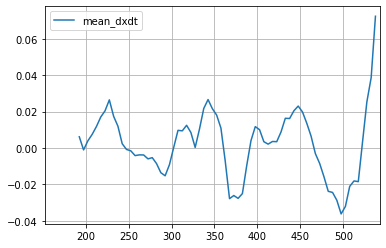

In [36]:
df_pd.groupby('y')['dxdt'].mean().to_frame(name='mean_dxdt').set_index(y_idx.mid).plot()
plt.grid()

---

## play with hvplot

In [37]:
df.hvplot(x='xgrid', y='ygrid', c='depth', cmap='viridis', kind='scatter',
          size=12, colorbar=True,
          datashade=True)

/Users/aponte/.miniconda3/envs/sandbox/lib/python3.7/site-packages/datashader/transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):


:DynamicMap   []
   :RGB   [xgrid,ygrid]   (R,G,B,A)

In [38]:
df.hvplot(x='xgrid', y='ygrid', cmap='viridis', kind='scatter',
          size=12, colorbar=True,
          rasterize=True, x_sampling=10, y_sampling=10) 
# import datashader as ds
# ds.reductions.mean('ygrid') no working ... should work, try again

:DynamicMap   []
   :Image   [xgrid,ygrid]   (Count)

---

## play with holoviews

In [39]:
import holoviews as hv
from holoviews import opts
from holoviews.operation.datashader import aggregate
import datashader.reductions as rd

renderer = hv.renderer('bokeh')
#renderer = hv.renderer('matplotlib')

In [40]:
# Set plot and style options
opts.defaults(
    opts.Curve(xaxis=None, yaxis=None, show_grid=False, show_frame=False,
               color='orangered', framewise=True, width=100),
    opts.Image(width=800, height=400, shared_axes=False, logz=True,
               xaxis=None, yaxis=None, axiswise=True),
    opts.HLine(color='white', line_width=1),
    opts.Layout(shared_axes=False),
    opts.VLine(color='white', line_width=1))

In [17]:
opts.defaults(
    opts.Curve(show_grid=False, show_frame=True,
               color='orangered', framewise=True, width=100),
    opts.Image(width=800, height=400, shared_axes=False, logz=True,
               axiswise=True),
    opts.HLine(color='white', line_width=1),
    opts.Layout(shared_axes=False),
    opts.VLine(color='white', line_width=1))

In [41]:
# Declare points
ds = hv.Dataset(df, ['xgrid', 'ygrid'], ['depth','temp'])

# Use datashader to rasterize and linked streams for interactivity
agg = aggregate(ds, aggregator=rd.mean('temp'), link_inputs=True, x_sampling=0.01, y_sampling=0.01)
#
pointerx = hv.streams.PointerX(x=np.mean(ds.range('xgrid')), source=ds)
pointery = hv.streams.PointerY(y=np.mean(ds.range('ygrid')), source=ds)
vline = hv.DynamicMap(lambda x: hv.VLine(x), streams=[pointerx])
hline = hv.DynamicMap(lambda y: hv.HLine(y), streams=[pointery])
#
sampled = hv.util.Dynamic(agg, operation=lambda obj, x: obj.sample(xgrid=x),
                          streams=[pointerx], link_inputs=False).opts(invert_axes=True)

(agg * hline * vline) + sampled
#(agg * hline * vline) << sampled # not working properly

:Layout
   .DynamicMap.I  :DynamicMap   []
      :Overlay
         .Image.I :Image   [xgrid,ygrid]   (temp)
         .HLine.I :HLine   [x,y]
         .VLine.I :VLine   [x,y]
   .DynamicMap.II :DynamicMap   []
      :Curve   [ygrid]   (temp)